In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
fold1_X_train = pd.read_csv('data/processed/fold_1_X_train.csv')
fold1_X_test = pd.read_csv('data/processed/fold_1_X_test.csv')  
fold1_y_train = pd.read_csv('data/processed/fold_1_y_train.csv').squeeze()
fold1_y_test = pd.read_csv('data/processed/fold_1_y_test.csv').squeeze()
fold2_X_train = pd.read_csv('data/processed/fold_2_X_train.csv')
fold2_X_test = pd.read_csv('data/processed/fold_2_X_test.csv')  
fold2_y_train = pd.read_csv('data/processed/fold_2_y_train.csv').squeeze()
fold2_y_test = pd.read_csv('data/processed/fold_2_y_test.csv').squeeze()

print("Ready for EDA")
print(f"  Data integrity verified: ✅")

Ready for EDA
  Data integrity verified: ✅


In [46]:
def explore_dataset(df, name="Dataset"):
    """
    Print basic information and statistics about a dataset (DataFrame).

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to explore.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)  # (rows, columns)
    print("Number of features:", df.shape[1])
    print("Number of samples:", df.shape[0])

    print("\n--- First 5 rows ---")
    print(df.head())

    print("\n--- Info ---")
    print(df.info())

    print("\n--- Statistics (numerical columns) ---")
    print(df.describe())

In [47]:
explore_dataset(fold1_X_train, name="Fold 1 X_train")
explore_dataset(fold2_X_train, name="Fold 2 X_train")


=== Fold 1 X_train ===
Shape: (8495, 18)
Number of features: 18
Number of samples: 8495

--- First 5 rows ---
   num__temp_C  num__dewpoint_C  num__slp_hPa  num__wind_dir_deg  \
0     1.118294         1.851607     -0.126166          -1.077484   
1     1.248428         0.584922     -0.725202          -0.211985   
2     1.161672         0.571154     -0.658642          -0.115819   
3     1.064071         0.653764     -0.671954          -0.500485   
4     1.042382         0.681301     -0.711890          -0.404318   

   num__precip_mm  cat__sky_cover_0  cat__sky_cover_0 -  cat__sky_cover_1  \
0        0.353852               0.0                 0.0               0.0   
1        0.353852               0.0                 1.0               0.0   
2        0.353852               0.0                 1.0               0.0   
3        0.353852               0.0                 1.0               0.0   
4        0.353852               0.0                 1.0               0.0   

   cat__sky_cover

In [48]:
def quality_report(df, name="Dataset"):
    """
    Print a quick quality report: missing values, data types, duplicates.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataset to check.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== Quality Report: {name} ===")
    
    # Missing values
    missing_data = df.isnull().sum()
    missing = missing_data[missing_data > 0]
    if not missing.empty:
        print("\nMissing values per column:")
        print(missing)
    else:
        print("\nNo missing values detected.")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")

In [49]:
quality_report(fold1_X_train, name="Fold 1 X_train")
quality_report(fold2_X_train, name="Fold 2 X_train")


=== Quality Report: Fold 1 X_train ===

No missing values detected.

Data types:
num__temp_C           float64
num__dewpoint_C       float64
num__slp_hPa          float64
num__wind_dir_deg     float64
num__precip_mm        float64
cat__sky_cover_0      float64
cat__sky_cover_0 -    float64
cat__sky_cover_1      float64
cat__sky_cover_1 -    float64
cat__sky_cover_5      float64
cat__sky_cover_5 -    float64
cat__sky_cover_6      float64
cat__sky_cover_6 -    float64
cat__sky_cover_7 -    float64
dt__dt__hour          float64
dt__dt__dow           float64
dt__dt__month         float64
dt__dt__is_weekend    float64
dtype: object

Duplicate rows: 2

=== Quality Report: Fold 2 X_train ===

No missing values detected.

Data types:
num__temp_C           float64
num__dewpoint_C       float64
num__slp_hPa          float64
num__wind_dir_deg     float64
num__precip_mm        float64
cat__sky_cover_0      float64
cat__sky_cover_0 -    float64
cat__sky_cover_1      float64
cat__sky_cover_1 -    f

In [50]:
# Basic target statistics
print("Target Variable Analysis:")
print(f"Mean: {fold1_y_train.mean()}")
print(f"Median: {fold1_y_train.median()}")
print(f"Standard Deviation: {fold1_y_train.std()}")
print(f"Minimum: {fold1_y_train.min()}")
print(f"Maximum: {fold1_y_train.max()}")

# Check for missing values in target
print(f"Missing values: {fold1_y_train.isnull().sum()}")

Target Variable Analysis:
Mean: 40.90103673543967
Median: 36.55599346
Standard Deviation: 24.771881843953242
Minimum: 0.97232599
Maximum: 300.0
Missing values: 0


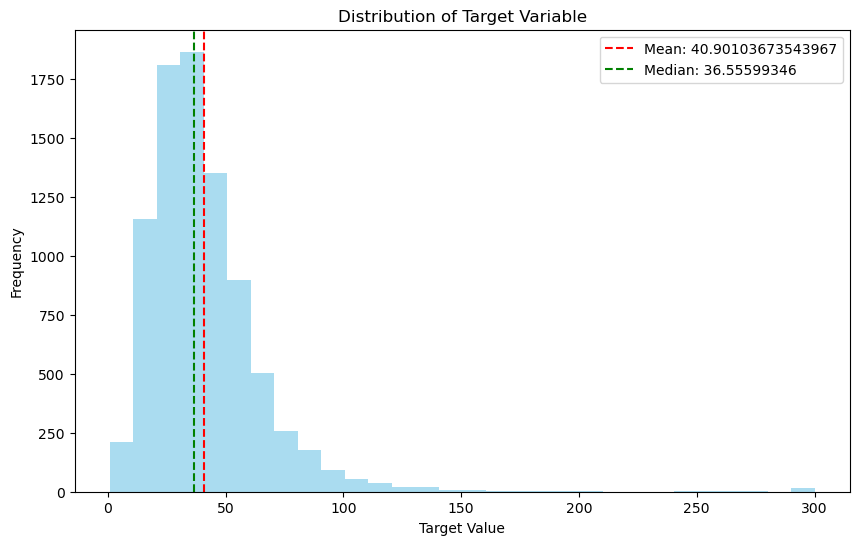

In [51]:
# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(fold1_y_train, bins=30, alpha=0.7, color='skyblue')
plt.axvline(fold1_y_train.mean(), color='red', linestyle='--', label=f'Mean: {fold1_y_train.mean()}')
plt.axvline(fold1_y_train.median(), color='green', linestyle='--', label=f'Median: {fold1_y_train.median()}')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()